In [1]:

%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import HTML

def display_sticky_table(df, height=400):
    html = f"""
    <style>
    .tableFixHead {{
        overflow-y: auto;
        height: {height}px;
    }}
    .tableFixHead thead th {{
        position: sticky;
        top: 0;
        background-color: gray;
        z-index: 1;
    }}
    </style>
    <div class="tableFixHead">
        {df.to_html()}
    </div>
    """
    return HTML(html)

In [3]:
seq_dict = {"601":"CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCTGTCCCCCGCGTTTTAACCGCCAAGGGGATTACTCCCTAGTCTCCAGGCACGTGTCAGATATATACATCCTGT", 
            "601RTA":"CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCTGTCTACCGCGTTTTAACCGCCAATAGGATTACTTACTAGTCTCCAGGCACGTGTCAGATATATACATCCTGT", 
            "601MF": "CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACACCGCGTACGTGCGTTTAAGCGGTGCTAGAGCTGTCTACTAGTCTCCAGGCACGTGTCAGATATATACATCCTGT",
            "601L": "CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCCGCGTACGTGCGTTTAAGCGGTGCTAGAGCTGTCTACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAG",
            "5S": "CTTCCAGGGATTTATAAGCCGATGACGTCATAACATCCCTGACCCTTTAAATAGCTTAACTTTCATCAAGCAAGAGCCTACGACCATACCATGCTGAATATACCGGTTCTCGTCCGATCACCGAAGTCAAGCAGCATAGGGCTCGGT"  }

nucmethod = "hybrid"

In [4]:
import os 
import sys
from py_analysis.modules.NucFreeEnergy import NucleosomeBreath
from py_analysis.config.custom_types import FreeEnergyResult, NuclBreathingResult
from py_analysis.config.gen_var import RESULTS_DIR, HARD_CONS
from typing import List
import concurrent.futures
from tqdm import tqdm
import pandas as pd



Source Directory: /home/pol_schiessel/maya620d/pol/Projects/Codebase/NucMonteCarlo
Output Directory: /home/pol_schiessel/maya620d/pol/Projects/Codebase/NucMonteCarlo


In [5]:

LEN_BOUND_SITES = 14
states = []
for left in range(LEN_BOUND_SITES):  # Left binding site: 0 to 13
    for right in range(left, LEN_BOUND_SITES):  # Right must be ≥ left
        states.append((left, right))

print(f"Total states index wise: {len(states)}")
## Use this for style="b_index"

##############################################################################
##############################################################################
##############################################################################
# This is the code to generate the states for the phosphate binding sites
# The phosphate binding sites are 0 to 27, and the left and right binding sites

LEN_PHOSPHATE_SITES = 28
ph_states = []
for left in range(LEN_PHOSPHATE_SITES):  # Left binding site: 0 to 27
    for right in range(left, LEN_PHOSPHATE_SITES):  # Right must be ≥ left
        ph_states.append((left, right))

print(f"Total phosphate states index wise: {len(ph_states)}")
## Use this for style="ph_index"

##############################################################################
##############################################################################
##############################################################################
## This is the code to generate the states for the open binding sites

# open_states = []
# for left in range(29): 
#     for right in range(29):  
#         if left+right <= 28: # Left and right binding sites must not exceed 28
#             open_states.append((left, right))

# print(f"Total open states: {len(open_states)}")
# ## Use this for style="open_sites"

Total states index wise: 105
Total phosphate states index wise: 406


In [6]:
KRESCFACTOR = 1.0
STYLE = "ph_index"  # Change this to "ph_index" for phosphate binding sites

if STYLE == "b_index":
    stat_list = states
    LENGTH = LEN_BOUND_SITES

elif STYLE == "ph_index":
    stat_list = ph_states
    LENGTH = LEN_PHOSPHATE_SITES

elif STYLE == "open_sites":
    stat_list = open_states
else:
    raise ValueError("Invalid style. Choose 'b_index', 'ph_index', or 'open_sites'.")

In [7]:

def energy_per_sequence(key, seq, nucmethod:str, bind_sates:List[tuple], factor, hard:bool=False, style:str="b_index")->  List[NuclBreathingResult]:
    nucleosomebreath = NucleosomeBreath(nuc_method=nucmethod)
    results:List[NuclBreathingResult] = []

    for bind_loc in bind_sates:

        if hard:
            free_energy = nucleosomebreath.calculate_free_energy_hard(seq147=seq,
                                                                    left=bind_loc[0], right=bind_loc[1], id=key)

        else:
            free_energy = nucleosomebreath.calculate_free_energy_soft(seq601=seq, 
                                                                  left=bind_loc[0], right=bind_loc[1], id=key, kresc_factor=factor, style=style)
            
        res_nucbreath = NuclBreathingResult(
            id=key,
            subid=None,
            sequence=seq,
            leftbind_indx=bind_loc[0],
            rightbind_indx=bind_loc[1],
            F_vals=free_energy
        )
        results.append(res_nucbreath)

    return results

results_all:List[NuclBreathingResult] = []
with concurrent.futures.ProcessPoolExecutor(max_workers=5) as executor:

    # futures = [executor.submit(energy_per_sequence, key=s, seq=seq_dict[s], nucmethod='hybrid', bind_sates=states, factor=KRESCFACTOR, hard=HARD_CONS, style="os") for s in seq_dict.keys()]
    futures = [executor.submit(energy_per_sequence, key=s, seq=seq_dict[s], nucmethod='hybrid', bind_sates=stat_list, factor=KRESCFACTOR, hard=HARD_CONS, style=STYLE) for s in list(seq_dict.keys())[:1]
]

    total = len(futures)

    for future in tqdm(concurrent.futures.as_completed(futures), total=total, desc="Processing sequences"):
        energy_array = future.result()
        results_all.extend(energy_array)

Processing sequences:   0%|          | 0/1 [00:00<?, ?it/s]

Using nucleosome method: hybrid
Using hang DNA method: md
Using hang stiffness: False


Processing sequences: 100%|██████████| 1/1 [03:14<00:00, 194.02s/it]


In [8]:

df_results = pd.DataFrame([result._asdict() for result in results_all])
df_free_energy = df_results['F_vals'].apply(lambda x: x._asdict() if hasattr(x, '_asdict') else x).apply(pd.Series)
df_free_energy = df_free_energy[['F', 'F_entropy', 'F_enthalpy', 'F_freedna']]

df_full = pd.concat([df_results.drop(columns=['F_vals']), df_free_energy], axis=1)
df_full["dF"] = df_full["F"] - df_full["F_freedna"]


In [9]:


if STYLE == "b_index" or STYLE == "ph_index":
    df_full["left_open"] = df_full["leftbind_indx"]
    df_full["right_open"] = df_full["rightbind_indx"].apply(lambda x: (LENGTH-1) - x)

else:
    df_full["left_open"] = df_full["leftbind_indx"]
    df_full["right_open"] = df_full["rightbind_indx"]


In [17]:
df_full

,id,subid,sequence,leftbind_indx,rightbind_indx,Adsorp_F,F,F_entropy,F_enthalpy,F_freedna,dF,left_open,right_open
0,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,0,0,0.0,1650.286369,1650.286369,0.000000,1650.286369,0.000000,0,27
1,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,0,1,0.0,1665.995831,1665.613760,0.382071,1650.286369,15.709463,0,26
2,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,0,2,0.0,1672.574046,1670.990585,1.583461,1650.286369,22.287678,0,25
3,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,0,3,0.0,1677.816020,1675.122383,2.693637,1650.286369,27.529651,0,24
4,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,0,4,0.0,1687.985819,1682.732454,5.253366,1650.286369,37.699451,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,25,26,0.0,1666.278105,1665.470497,0.807608,1650.286369,15.991736,25,1
402,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,25,27,0.0,1672.807318,1671.261125,1.546193,1650.286369,22.520949,25,0
403,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,26,26,0.0,1650.286369,1650.286369,0.000000,1650.286369,0.000000,26,1
404,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,26,27,0.0,1666.151358,1665.700173,0.451184,1650.286369,15.864989,26,0


In [8]:
if HARD_CONS:
    df_full.to_csv(RESULTS_DIR / f"nbfiles/nucbreathfe/breathstatefe_K{KRESCFACTOR}_hc.csv", index=False)
else:
    df_full.to_csv(RESULTS_DIR / f"nbfiles/nucbreathfe/breathstatefe_K{KRESCFACTOR}_sc.csv", index=False)


# df_full.to_csv("free_energy_results_hard.csv", index=False)

# Plotting

In [119]:
KRESCFACTOR = 1.0

if HARD_CONS:
    ############## HARD CONSTRAITNS ######################
    df_full = pd.read_csv(RESULTS_DIR / f"nbfiles/nucbreathfe/breathstatefe_K{KRESCFACTOR}_hc.csv")
else:
    ############## SOFT CONSTRAINTS ######################
    df_full = pd.read_csv(RESULTS_DIR / f"nbfiles/nucbreathfe/breathstatefe_K{KRESCFACTOR}_sc.csv")

In [120]:
import numpy as np
import matplotlib.pyplot as plt

from py_analysis.utils.plot_2d_heatmaps import plot_probability_heatmaps

from py_analysis.utils.plot_3d import plot_3d_filled_volume

/tmp/ipykernel_1002047/843268016.py:28: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



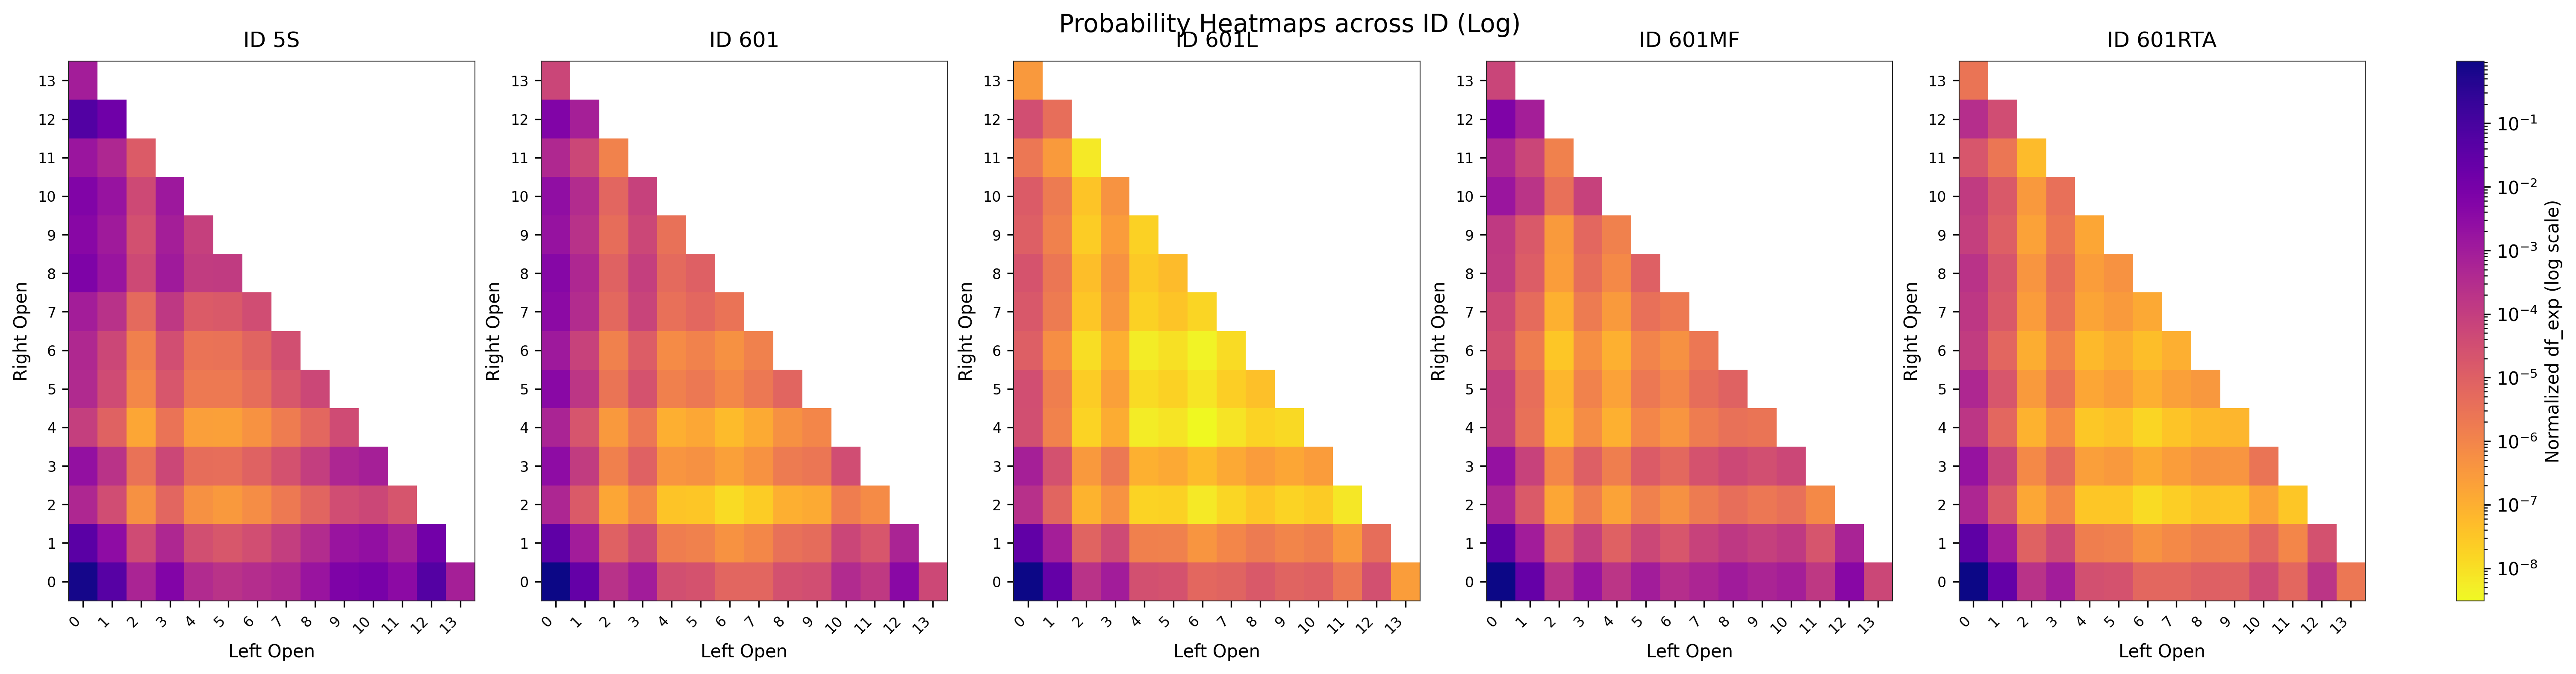

In [123]:

E_ads=16.5

df_full["Adsorp_F"]= -E_ads*(14-(df_full["left_open"]+df_full["right_open"]))

# df_full = apply_Eads(df_full, E_ads_high=26.0, E_ads_low=25.0)

df_full["dF_total"] = df_full["dF"] + df_full["Adsorp_F"]
# df_full["dF_total"] = df_full["F_enthalpy"] + df_full["Adsorp_F"]


df_full["df_exp"]= df_full["dF_total"].apply(lambda x: np.exp(-x))
df_full["df_exp_norm"] = df_full.groupby("id")["df_exp"].transform(lambda x: x / x.sum())


fig, axs = plot_probability_heatmaps(
    df_full,
    value_col='df_exp_norm',
    id_col='id',
    x_col='left_open',
    y_col='right_open',
    xlabel='Left Open',
    ylabel='Right Open',
    log_scale=True,
    colormap='plasma_r',
    figsize=(20, 5),
    suptitle="Probability Heatmaps across ID (Log)", dpi=300, colorbar_label = 'Normalized df_exp (log scale)'
)
fig.show()

In [91]:
fig2 = plot_3d_filled_volume(
    df_full,
    x_col='left_open', y_col='right_open', z_col='dF_total',
    x_label='Left Opening',
    y_label='Right Opening',
    z_label='ΔF (kT)',
    width=800, height=600,
    title='Free‐Energy Landscapes',
    colorscale='Plasma_r'
)
fig2.show()


# Fitting the Adsorption Energy to Michelle Wang data (2012)

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from py_analysis.config.gen_var import RESULTS_DIR, DATA_DIR


In [66]:
phosphate_sites = [2, 6, 14, 17, 24, 29, 34, 38, 
                                    45, 49, 55, 59, 65, 69, 76, 
                                    80, 86, 90, 96, 100, 107, 111, 
                                    116, 121, 128, 131, 139, 143]

In [67]:
left_zip_df = pd.read_csv(DATA_DIR / f"Hall_forward_zip_dwelltime_clean.csv", header=None, names=["basepair", "dwelltime"])
right_zip_df = pd.read_csv(DATA_DIR / f"Hall_reverse_zip_dwelltime_clean.csv", header=None, names=["basepair", "dwelltime"])

left_zip_df["bp_pos"] = left_zip_df["basepair"]+73
left_zip_df.loc[left_zip_df['dwelltime'] < 0, 'dwelltime'] = 0
left_zip_df = left_zip_df.sort_values('bp_pos')
left_zip_df['cumulative_dwell_time'] = left_zip_df['dwelltime'].cumsum()

right_zip_df["bp_pos"] = right_zip_df["basepair"]+73
right_zip_df.loc[right_zip_df['dwelltime'] < 0, 'dwelltime'] = 0
right_zip_df = right_zip_df.sort_values('bp_pos')
right_zip_df['cumulative_dwell_time'] = right_zip_df['dwelltime'][::-1].cumsum()[::-1] ## cumulative sum for right zip

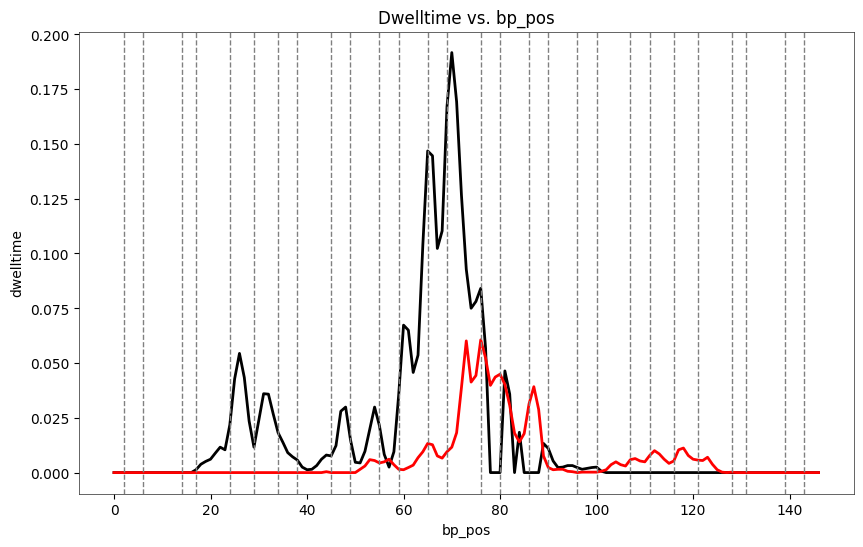

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(left_zip_df['bp_pos'], left_zip_df['dwelltime'], lw=2, color='black', label='Left Zip')
plt.plot(right_zip_df['bp_pos'], right_zip_df['dwelltime'], lw=2, color='red', label='Right Zip')
for site in phosphate_sites:
    plt.axvline(site, color='gray', linestyle='--', lw=1)
plt.xlabel('bp_pos')
plt.ylabel('dwelltime')
plt.title('Dwelltime vs. bp_pos')
# plt.grid(True)
plt.show()

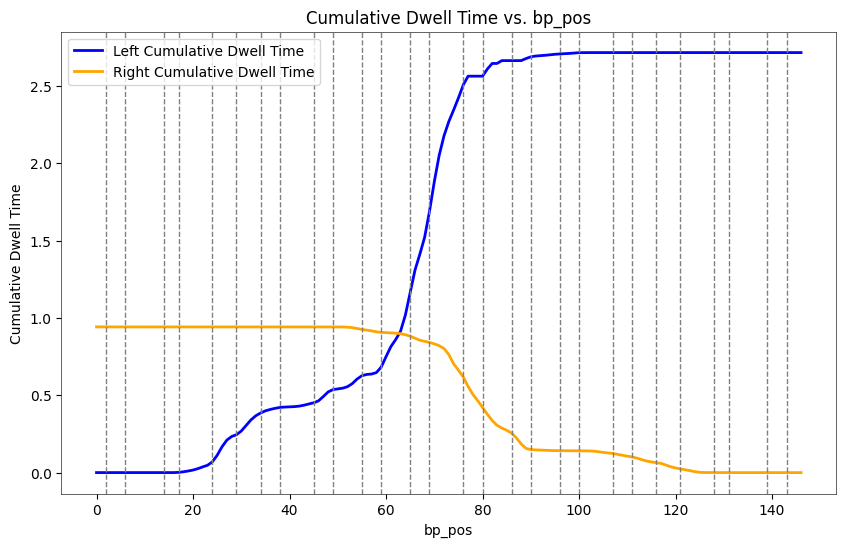

In [75]:
plt.figure(figsize=(10, 6))

plt.plot(left_zip_df['bp_pos'], left_zip_df['cumulative_dwell_time'], lw=2, color='blue', label='Left Cumulative Dwell Time')
plt.plot(right_zip_df['bp_pos'], right_zip_df['cumulative_dwell_time'], lw=2, color='orange', label='Right Cumulative Dwell Time')
for site in phosphate_sites:
    plt.axvline(site, color='gray', linestyle='--', lw=1)
plt.xlabel('bp_pos')
plt.ylabel('Cumulative Dwell Time')
plt.title('Cumulative Dwell Time vs. bp_pos')
plt.legend()
plt.show()


In [68]:
left_ph_df =  left_zip_df[left_zip_df['bp_pos'].isin(phosphate_sites)]

## Subtract 1 from the bp_pos because when zipping from right the bp will be of right to the bound phosphate. And since in the phosphate_sites 
## we are using the left base pair to represent the phosphate site, I need to make sure I select the dwell time for the base pair that is in the right 
## of the phosphate site, when I zip from the right.
right_zip_df["aligned_bp_position"] = right_zip_df["bp_pos"] - 1 ## This is to select the phosphate sites from the array. And also to match the left zip data. 

right_ph_df =  right_zip_df[right_zip_df['aligned_bp_position'].isin(phosphate_sites)]

# right_ph_df =  right_zip_df[right_zip_df['bp_pos'].isin(phosphate_sites)]

df_merged_dwell = pd.merge(left_ph_df, right_ph_df, left_on='bp_pos', right_on="aligned_bp_position", suffixes=('_left', '_right'))


In [69]:
df_merged_dwell_selcol = df_merged_dwell[["bp_pos_left", "cumulative_dwell_time_left", "cumulative_dwell_time_right"]]
df_merged_dwell_selcol.rename(columns={"bp_pos_left":"phosphate_site", 
                                        "cumulative_dwell_time_left":"left_cumdwell_time", 
                                        "cumulative_dwell_time_right":"right_cumdwell_time"}, 
                                        inplace=True)

/tmp/ipykernel_13503/3139504063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_dwell_selcol.rename(columns={"bp_pos_left":"phosphate_site",


In [70]:
KRESCFACTOR = 1.0

if HARD_CONS:
    ############## HARD CONSTRAITNS ######################
    df_full = pd.read_csv(RESULTS_DIR / f"nbfiles/dna_histone/breathstatefe_K{KRESCFACTOR}_hc.csv")
else:
    ############## SOFT CONSTRAINTS ######################
    df_full = pd.read_csv(RESULTS_DIR / f"nbfiles/dna_histone/breathstatefe_K{KRESCFACTOR}_sc.csv")

df_full = df_full[df_full["id"]=="601"]


#############################################
#####FLIPPED SEQUENCE #######################
#############################################
df_full_flip = pd.read_csv(RESULTS_DIR / f"nbfiles/dna_histone/breathstatefe_K{KRESCFACTOR}_sc_flip.csv")
df_full_flip = df_full_flip[df_full_flip["id"]=="601"]

In [71]:
df_full_left = df_full[df_full['right_open']==0].reset_index(drop=True)
df_full_right = df_full[df_full['left_open']==0].reset_index(drop=True)


df_full_left['phosphate_site'] = np.where(
    df_full_left['leftbind_indx'] < len(phosphate_sites),
    df_full_left['leftbind_indx'].astype(int).map(lambda i: phosphate_sites[i]),
    np.nan
)

df_full_right['phosphate_site'] = np.where(
    df_full_left['leftbind_indx'] < len(phosphate_sites),
    df_full_left['leftbind_indx'].astype(int).map(lambda i: phosphate_sites[i]),
    np.nan
)

df_full_left = df_full_left[["phosphate_site", "id", "F", "F_entropy", "F_enthalpy", "F_freedna", "dF"]]
df_full_right = df_full_right[["phosphate_site", "id", "F", "F_entropy", "F_enthalpy", "F_freedna", "dF"]]


#############################################
#####FLIPPED SEQUENCE #######################
#############################################
df_full_flip_left = df_full_flip[df_full_flip['right_open']==0].reset_index(drop=True)
df_full_flip_right = df_full_flip[df_full_flip['left_open']==0].reset_index(drop=True)
df_full_flip_left['phosphate_site'] = np.where(
    df_full_flip_left['leftbind_indx'] < len(phosphate_sites),
    df_full_flip_left['leftbind_indx'].astype(int).map(lambda i: phosphate_sites[i]),
    np.nan
)
df_full_flip_right['phosphate_site'] = np.where(
    df_full_flip_left['leftbind_indx'] < len(phosphate_sites),
    df_full_flip_left['leftbind_indx'].astype(int).map(lambda i: phosphate_sites[i]),
    np.nan
)
df_full_flip_left = df_full_flip_left[["phosphate_site", "id", "F", "F_entropy", "F_enthalpy", "F_freedna", "dF"]]
df_full_flip_right = df_full_flip_right[["phosphate_site", "id", "F", "F_entropy", "F_enthalpy", "F_freedna", "dF"]]




In [110]:
df_time = df_merged_dwell_selcol.copy()

kBT   = 1.0                                    
tau_0 = 1e-6                               

# ---------- LEFT  (forward)  ------------------
tau_L = df_time['left_cumdwell_time'].diff().fillna(df_time['left_cumdwell_time'].iloc[0]) # first row has no upstream neighbour, so filled with its own value


dG_L  = df_full_left['dF'].diff().shift(-1)         
dG_L_enthaply  = df_full_left['F_enthalpy'].diff().shift(-1)         

dG_L.iloc[-1] = 0                               
tau_L = tau_L.reset_index(drop=True)               
dG_L  = dG_L.reset_index(drop=True)                

Eads_L_full = kBT*np.log(tau_L / tau_0) - dG_L
Eads_L_full_enthalpy = kBT*np.log(tau_L / tau_0) - dG_L_enthaply 
Eads_L = kBT*np.log(tau_L / tau_0) 



# ---------- RIGHT  (reverse) ------------------
cumT_R = df_time['right_cumdwell_time'][::-1].reset_index(drop=True)
cumF_R = df_full_right['dF'][::-1].reset_index(drop=True)
cumF_R_enthalpy = df_full_right['F_enthalpy'][::-1].reset_index(drop=True)


tau_R = cumT_R.diff().fillna(cumT_R.iloc[0])      
dG_R  = cumF_R.diff().shift(-1)                   
dG_R.iloc[-1] = 0

dG_R_enthalpy  = cumF_R_enthalpy.diff().shift(-1)                   
dG_R_enthalpy.iloc[-1] = 0

tau_R = tau_R[::-1].reset_index(drop=True)
dG_R  = dG_R[::-1].reset_index(drop=True)
dG_R_enthalpy  = dG_R_enthalpy[::-1].reset_index(drop=True)

Eads_R_full = kBT*np.log(tau_R / tau_0) - dG_R
Eads_R_full_enthalpy = kBT*np.log(tau_R / tau_0) - dG_R_enthalpy
Eads_R = kBT*np.log(tau_R / tau_0)



Eads_R = Eads_R.replace([np.inf, -np.inf], 0)
Eads_L = Eads_L.replace([np.inf, -np.inf], 0)

Eads_R_full_enthalpy = Eads_R_full_enthalpy.replace([np.inf, -np.inf], 0)
Eads_L_full_enthalpy = Eads_L_full_enthalpy.replace([np.inf, -np.inf], 0)

Eads_L_full = Eads_L_full.replace([np.inf, -np.inf], 0)
Eads_R_full = Eads_R_full.replace([np.inf, -np.inf], 0)


/home/pol_schiessel/maya620d/anaconda3/envs/nucleosome/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [111]:
df_time_flip = df_merged_dwell_selcol.copy()

kBT   = 1.0                                    

# ---------- LEFT  (forward)  ------------------
tau_L_flip = df_time_flip['left_cumdwell_time'].diff().fillna(df_time_flip['left_cumdwell_time'].iloc[0]) # first row has no upstream neighbour, so filled with its own value


dG_L_flip  = df_full_flip_left['dF'].diff().shift(-1)         
dG_L_enthaply_flip  = df_full_flip_left['F_enthalpy'].diff().shift(-1)         

dG_L_flip.iloc[-1] = 0                               
tau_L_flip = tau_L_flip.reset_index(drop=True)               
dG_L_flip  = dG_L_flip.reset_index(drop=True)                

# Eads_L_full_flip = kBT*np.log(tau_L_flip / tau_0) - dG_L_flip
# Eads_L_full_enthalpy_flip = kBT*np.log(tau_L_flip / tau_0) - dG_L_enthaply_flip 
# Eads_L_flip = kBT*np.log(tau_L_flip / tau_0) 



# ---------- RIGHT  (reverse) ------------------
cumT_R_flip = df_time_flip['right_cumdwell_time'][::-1].reset_index(drop=True)
cumF_R_flip = df_full_flip_right['dF'][::-1].reset_index(drop=True)
cumF_R_enthalpy_flip = df_full_flip_right['F_enthalpy'][::-1].reset_index(drop=True)


tau_R_flip = cumT_R_flip.diff().fillna(cumT_R_flip.iloc[0])      
dG_R_flip  = cumF_R_flip.diff().shift(-1)                   
dG_R_flip.iloc[-1] = 0

dG_R_enthalpy_flip  = cumF_R_enthalpy_flip.diff().shift(-1)                   
dG_R_enthalpy_flip.iloc[-1] = 0

tau_R_flip = tau_R_flip[::-1].reset_index(drop=True)
dG_R_flip  = dG_R_flip[::-1].reset_index(drop=True)
dG_R_enthalpy_flip  = dG_R_enthalpy_flip[::-1].reset_index(drop=True)

# Eads_R_full_flip = kBT*np.log(tau_R_flip / tau_0) - dG_R_flip
# Eads_R_full_enthalpy_flip = kBT*np.log(tau_R_flip / tau_0) - dG_R_enthalpy_flip
# Eads_R_flip = kBT*np.log(tau_R_flip / tau_0)



Eads_L_full_flip = kBT*np.log(tau_R_flip / tau_0) - dG_L_flip
Eads_L_full_enthalpy_flip = kBT*np.log(tau_R_flip / tau_0) - dG_L_enthaply_flip 
Eads_L_flip = kBT*np.log(tau_R_flip / tau_0) 

Eads_R_full_flip = kBT*np.log( tau_L_flip/ tau_0) - dG_R_flip
Eads_R_full_enthalpy_flip = kBT*np.log(tau_L_flip / tau_0) - dG_R_enthalpy_flip
Eads_R_flip = kBT*np.log(tau_L_flip / tau_0)


Eads_R_flip = Eads_R_flip.replace([np.inf, -np.inf], 0)
Eads_L_flip = Eads_L_flip.replace([np.inf, -np.inf], 0)

Eads_R_full_enthalpy_flip = Eads_R_full_enthalpy_flip.replace([np.inf, -np.inf], 0)
Eads_L_full_enthalpy_flip = Eads_L_full_enthalpy_flip.replace([np.inf, -np.inf], 0)

Eads_L_full_flip = Eads_L_full_flip.replace([np.inf, -np.inf], 0)
Eads_R_full_flip = Eads_R_full_flip.replace([np.inf, -np.inf], 0)


In [112]:
df_dG = pd.DataFrame({
    "phosphate_site": phosphate_sites,
    'dG_L': dG_L,
    'dG_R': dG_R,
    'dG_L_flip': dG_L_flip,
    'dG_R_flip': dG_R_flip
})


df_Eads_full = pd.DataFrame({
    "phosphate_site": phosphate_sites,
    'Eads_L_full': Eads_L_full,
    'Eads_R_full': Eads_R_full,
    'Eads_L_full_flip': Eads_L_full_flip,
    'Eads_R_full_flip': Eads_R_full_flip
})


df_Eads_enthalpy = pd.DataFrame({
    "phosphate_site": phosphate_sites,
    'Eads_L_full_enthalpy': Eads_L_full_enthalpy,
    'Eads_R_full_enthalpy': Eads_R_full_enthalpy,
    'Eads_L_full_enthalpy_flip': Eads_L_full_enthalpy_flip,
    'Eads_R_full_enthalpy_flip': Eads_R_full_enthalpy_flip
})


In [113]:
df_dG

,phosphate_site,dG_L,dG_R,dG_L_flip,dG_R_flip
0,2,-5.634201,0.000000,-5.510130,0.000000
1,6,-7.288578,-15.709463,-7.468095,-15.679366
2,14,-4.782815,-6.578215,-5.230055,-6.691827
3,17,-6.942553,-5.241974,-7.045080,-5.473917
4,24,-8.762956,-10.169799,-9.837158,-10.450857
5,29,-9.245190,-9.022229,-8.918722,-9.841126
6,34,-6.509266,-5.996879,-7.314851,-5.558374
7,38,-6.548580,-8.695452,-7.254669,-9.323902
8,45,-7.385644,-10.060561,-8.826727,-11.052248
9,49,-8.874297,-6.713919,-9.419062,-8.072706


0
1
2
0
1
2


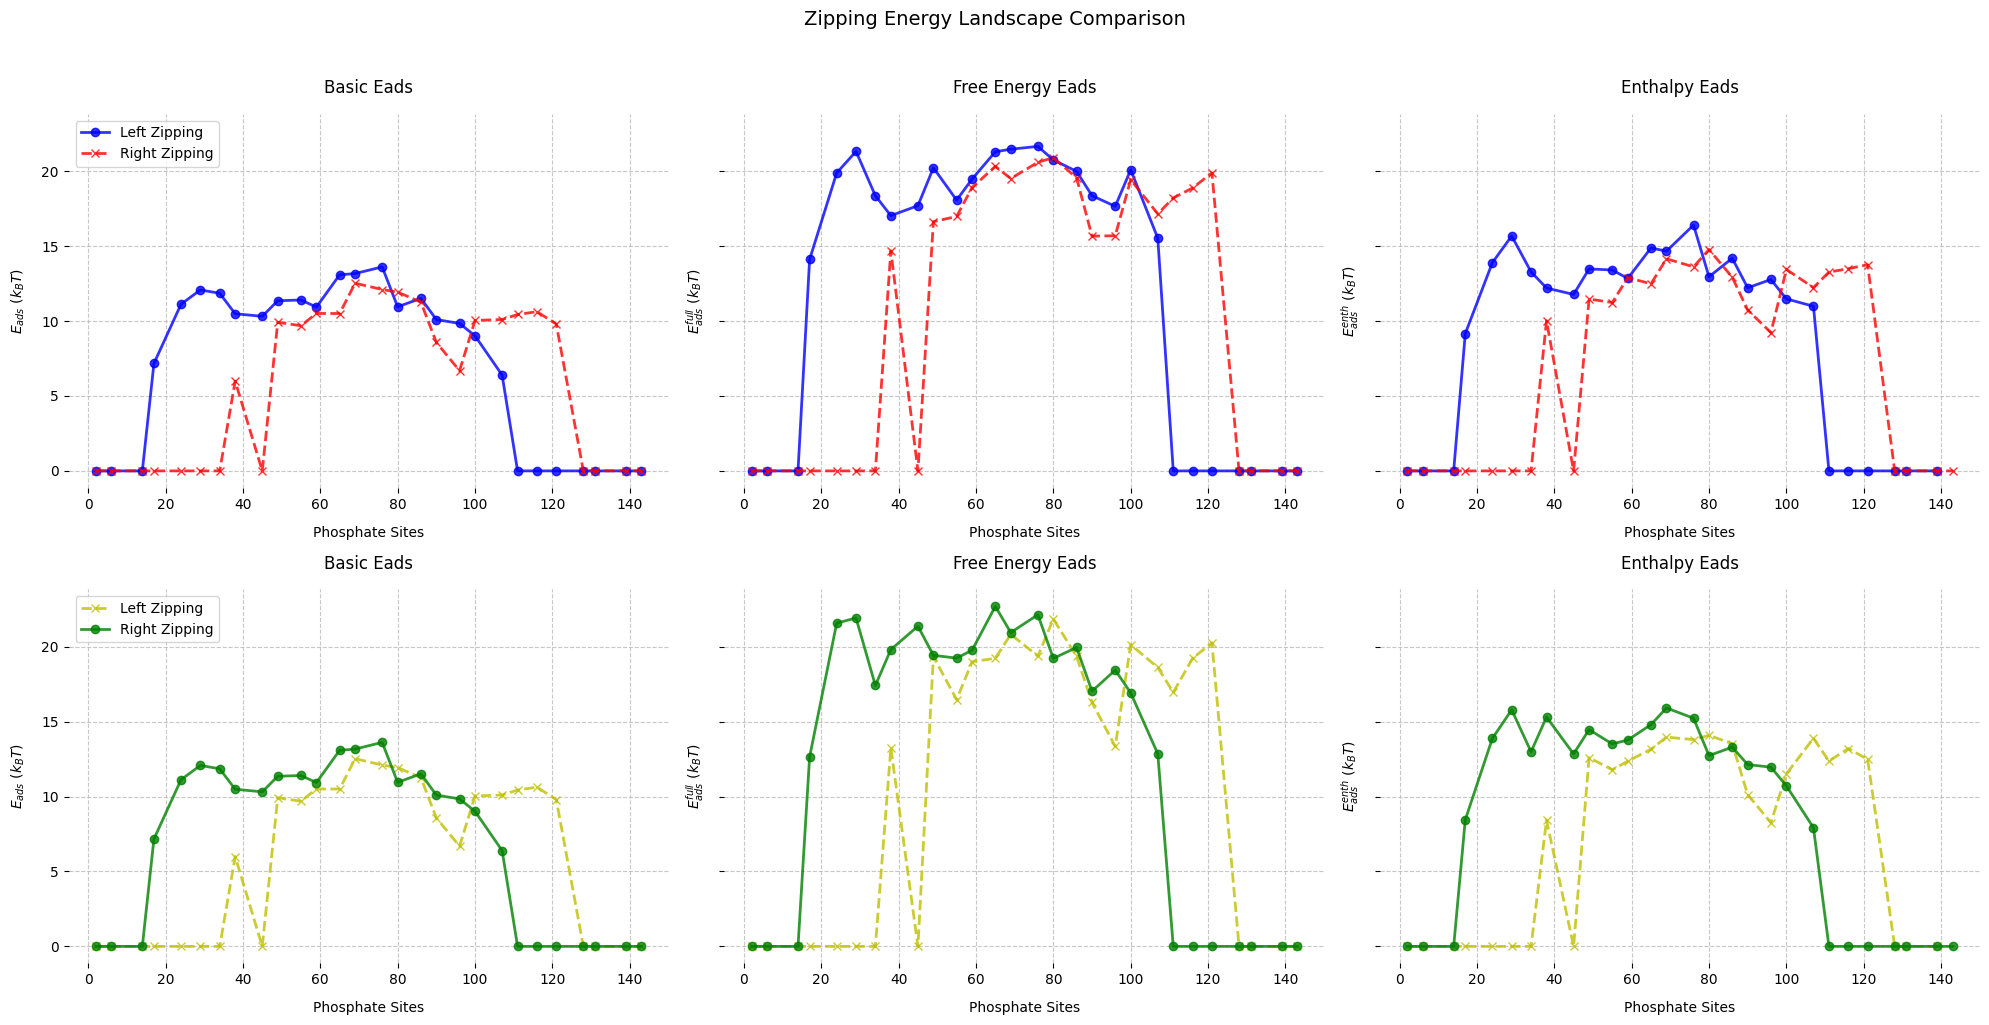

In [119]:
import seaborn as sns
fig, axs = plt.subplots(2, 3, figsize=(20, 10), sharey=True, sharex=False)
fig.tight_layout(pad=2.0)

# Plot configuration
plot_config = [
    (Eads_L, Eads_R, "Basic Eads", r"$E_{ads}\ (k_B T)$"),
    (Eads_L_full, Eads_R_full, "Free Energy Eads", r"$E_{ads}^{full}\ (k_B T)$"),
    (Eads_L_full_enthalpy, Eads_R_full_enthalpy, 
        "Enthalpy Eads", r"$E_{ads}^{enth}\ (k_B T)$")
]

plot_config_flip = [
    (Eads_L_flip, Eads_R_flip, "Basic Eads", r"$E_{ads}\ (k_B T)$"),
    (Eads_L_full_flip, Eads_R_full_flip, "Free Energy Eads", r"$E_{ads}^{full}\ (k_B T)$"),
    (Eads_L_full_enthalpy_flip, Eads_R_full_enthalpy_flip, 
        "Enthalpy Eads", r"$E_{ads}^{enth}\ (k_B T)$")
]


for idx, (left_data, right_data, title, ylabel) in enumerate(plot_config):
    # Create common x-axis index
    print (idx)
    
    # Plot data
    axs[0,idx].plot(phosphate_sites, left_data, 'b-', label='Left Zipping', linewidth=2, alpha=0.8, marker='o')
    axs[0,idx].plot(phosphate_sites, right_data, 'r--', label='Right Zipping', linewidth=2, alpha=0.8, marker='x')
    
    # Formatting
    axs[0,idx].set_title(title, pad=15)
    axs[0,idx].set_xlabel("Phosphate Sites", labelpad=10)
    axs[0,idx].set_ylabel(ylabel, labelpad=10)
    axs[0,idx].grid(True, linestyle='--', alpha=0.7)
    # axs[idx].legend(loc='upper left', frameon=True)
    
    # Remove spines
    sns.despine(ax=axs[0, idx], left=True, bottom=True)


for idx, (left_data, right_data, title, ylabel) in enumerate(plot_config_flip):
    # Create common x-axis index
    print (idx)
    
    # Plot data
    axs[1,idx].plot(phosphate_sites, left_data, 'y--', label='Left Zipping', linewidth=2, alpha=0.8, marker='x')
    axs[1,idx].plot(phosphate_sites, right_data, 'g-', label='Right Zipping', linewidth=2, alpha=0.8, marker='o')
    
    # Formatting
    axs[1,idx].set_title(title, pad=15)
    axs[1,idx].set_xlabel("Phosphate Sites", labelpad=10)
    axs[1,idx].set_ylabel(ylabel, labelpad=10)
    axs[1,idx].grid(True, linestyle='--', alpha=0.7)
    # axs[idx].legend(loc='upper left', frameon=True)
    
    # Remove spines
    sns.despine(ax=axs[1, idx], left=True, bottom=True)


axs[0,0].legend(loc='upper left', frameon=True)
axs[1,0].legend(loc='upper left', frameon=True)
# Global title
plt.suptitle("Zipping Energy Landscape Comparison", y=1.02, fontsize=14)

# Adjust layout and display
plt.tight_layout()
plt.show()

